The NLR7301 is a supercritical airfoil which has been modified to a two-element configuration with a non-retractable flap. 
This configuration and the measurements were designed for the purpose of CFD validation[1]. 
The measurements were taken in 1979 and includes detailed pressure distributions, transition onset locations and someboundary layer velocity profiles for the angles of attack 6° and 13.1°. 
These measurements have been used extensively for another viscid-inviscid interaction method[2] as well as Navier Stokes codes, e.g.[3]. 
There is a single measurement set available, at a Reynolds Number of 2.51E6 and a Mach Number of .185, comprising a set of 16 lift and 3 drag values.

The airfoil coordinates were derived from a grid provided on this webpage https://www.kbwiki.ercoftac.org/w/index.php?title=UFR_3-01_Description for the project ECARP[7].

In [1]:
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.figure_format = 'svg'


import logging
logging.getLogger().setLevel(logging.INFO)

# Read and panel airfoil data
MAIN = vft.repanel(vft.read_selig("NLR7301MainECARP.dat"),260)[:,::-1] #180
FLAP0 = vft.repanel(vft.read_selig("NLR7301FlapECARP.dat"),220)[:,::-1] #150

The authors note an offset in the change in distance between flap and main airfoil, as well as a change in twist on the flap. 
This change is applied below, by shifting and rotating the flap.
Such a modification was also used in the analysis in [6].

<IPython.core.display.Javascript object>


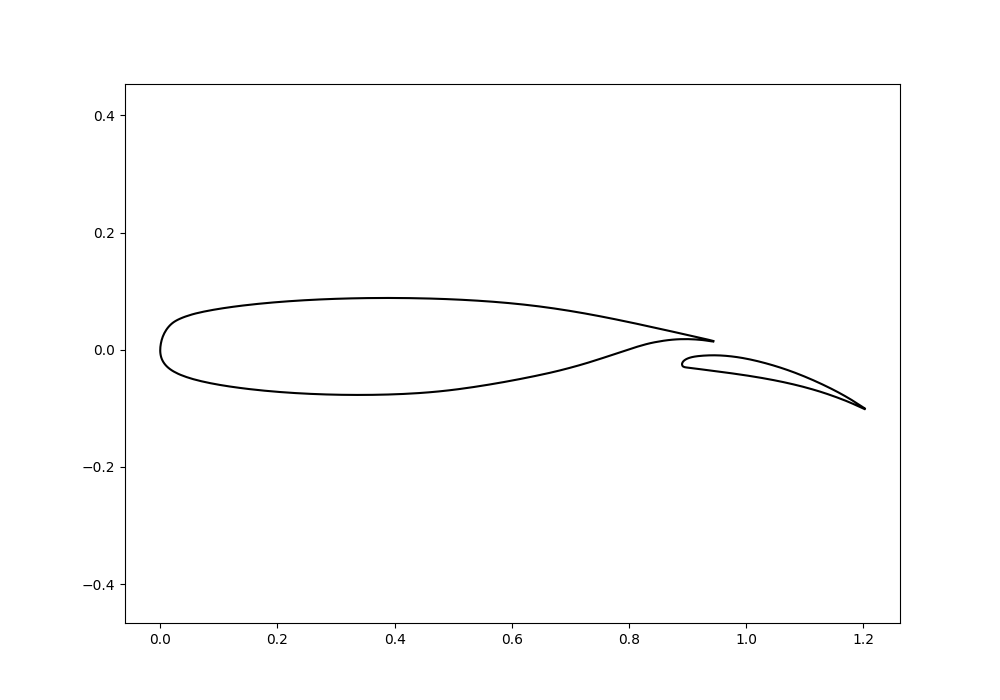

In [2]:
matplotlib.rcParams['figure.figsize'] = [10, 7] # Make plots bigger than default

# Rotate flap
center = np.r_[0.94,-0.011]
def rotate(deg,center,x):
    c, s = np.cos(deg*np.pi/180), np.sin(deg*np.pi/180)
    A = np.array([[c, s], [-s, c]])
    # The following transposing is done, because numpy subtracts 1x2 arrays from a Nx2 array, 
    # but not 2x1 arrays form an 2xN array.
    return ((A@((x.T-center.T).T)).T+center.T).T

FLAP = rotate(-.25,center,FLAP0)
FLAP[1,:] += 0.0025

# Plot geometry
fig,ax = plt.subplots(1,1)
ax.plot(MAIN[0,:],MAIN[1,:],'-k')
ax.plot(FLAP[0,:],FLAP[1,:],'-k')
ax.axis("equal");


## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0 or 0.185 using a Karman-Tsien correction for the pressure and lift. A critical amplification factor of 8 was used, while 11.2 seems to be recommended for the Delft low-speed wind tunnel[5].
However, the lower value agrees better with the observed transition (see the pressure distributions below).

In [3]:
# Settings
RE = 2.51e6
ncrit = 8
Mach = 0.0
AOArange = np.arange(-2,17,.5)

s = vf.setup(Re=RE,Ncrit=ncrit,Ma=Mach,Alpha=AOArange[0])
s.Silent = False # Do not show information on convergence and iterations

# RFOIL-type shear lag fits the measurement slightly better (lower maximum lift)
s.ShearLagType = 1

results = {} # Dictionary of results
Mach_vec = [0,0.185]
res13 = {}
for val in Mach_vec:
    s.Ma = val
    
    # When using an outer loop, make sure to re-initialize the solution 
    Init = True
    
    results[val] = {}
    results[val]["AOA"] = []
    results[val]["CL"] = []
    results[val]["CLi"] = []
    results[val]["CD"] = []
    
    for alpha in AOArange:
        s.Alpha = alpha
        
        if Init:
            [p,bl,xn] = vf.init([MAIN,FLAP],s)
            Init = False
            

        res = None
        grad = None
        [xn,flag,res,grad,_] = vf.iter(xn,bl,p,s,res,grad)
        resi = np.sqrt(np.dot(res.T,res))
        
        if flag:
            results[val]["AOA"].append(alpha)
            results[val]["CL"].append(p.CL)
            results[val]["CLi"].append(p.CLi)
            results[val]["CD"].append(bl[0].CD)
            print('AOA %2.2f CL %f'%(alpha,p.CL))


Iteration 18, |res| 0.000014, lam 1.000000
AOA -2.00 CL 1.401373
Iteration 8, |res| 0.000093, lam 0.655715
AOA -1.50 CL 1.470271
Iteration 7, |res| 0.000021, lam 1.000000
AOA -1.00 CL 1.538964
Iteration 10, |res| 0.000080, lam 0.500000
AOA -0.50 CL 1.607154
Iteration 8, |res| 0.000075, lam 0.500000
AOA 0.00 CL 1.675405
Iteration 10, |res| 0.000097, lam 0.500000
AOA 0.50 CL 1.742870
Iteration 8, |res| 0.000081, lam 0.500000
AOA 1.00 CL 1.810478
Iteration 8, |res| 0.000035, lam 0.828608
AOA 1.50 CL 1.877723
Iteration 8, |res| 0.000070, lam 0.500000
AOA 2.00 CL 1.944565
Iteration 7, |res| 0.000084, lam 0.500000
AOA 2.50 CL 2.011029
Iteration 10, |res| 0.000074, lam 0.500000
AOA 3.00 CL 2.077056
Iteration 13, |res| 0.000069, lam 0.500000
AOA 3.50 CL 2.140880
Iteration 7, |res| 0.000070, lam 0.500000
AOA 4.00 CL 2.205928
Iteration 8, |res| 0.000068, lam 0.500000
AOA 4.50 CL 2.270561
Iteration 9, |res| 0.000047, lam 0.655346
AOA 5.00 CL 2.334526
Iteration 11, |res| 0.000049, lam 0.549224
AOA

In [5]:
# Read experimental data
EXPRES=np.genfromtxt("NLRLIFTSLOPE.csv",delimiter=",",names=True)

fix,ax = plt.subplots(1,2)
ax[0].plot(EXPRES['MEAS_X'],EXPRES['MEAS_Y'],marker=".",linestyle = 'None', color="tab:blue",label="Experimental Lift")
for val in Mach_vec:
    ax[0].plot(np.array(results[val]["AOA"]),np.asarray(results[val]["CL"]),marker=None,label="Calculation Mach %g"%val)
ax[0].plot(np.array(results[val]["AOA"]),results[val]["CLi"],marker=None,label="Inviscid Lift")

ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[0].legend()
ax[0].set_xlim([-2, 17])
ax[0].set_ylim([1.5, 3.5])

EXPRESD=np.genfromtxt("NLRDRAGSLOPE.csv",delimiter=",",names=True)
ax[1].plot(EXPRESD['MEAS_X'],EXPRESD['MEAS_Y'],marker=".",linestyle = 'None', color="tab:blue",label="Experimental Drag")
for val in Mach_vec:
    ax[1].plot(results[val]["AOA"],results[val]["CD"],marker=None,label="Calculation Mach %g"%val)

ax[1].set_ylim([0, 0.08]) 
ax[1].set_xlim([-2, 17])
ax[1].set_xlabel('AOA')
ax[1].set_ylabel('CD')
ax[1].legend();

<IPython.core.display.Javascript object>

KeyError: 0.185

The viscous calculations accurately predict the change in lift slope compared to the inviscid calculations. 
Applying the Mach corrections does result in a worse prediction compared to the incompressible calculation.
This seems to be in line with the results in [2], where the authors choose not to use a Mach correction for this case, but do use one for another case at the same Mach number.
In the following, the pressure distributions are compared to the incompressible calculations.

In [6]:
# Set-up and initialize based on inviscid panel solution
s.Ma = 0.0

# Experimental 6° has the same lift as numerical 5.5°
s.Alpha = 6
[p6,bl6,x] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl6,p6,s,None,None)

# Experimental 13.1° has the same lift as numerical 12.6°
s.Alpha = 13.1
[p13,bl13,_] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl13,p13,s,None,None)

Exception: Number of airfoils (2) exceeds available (1) this version of viiflow

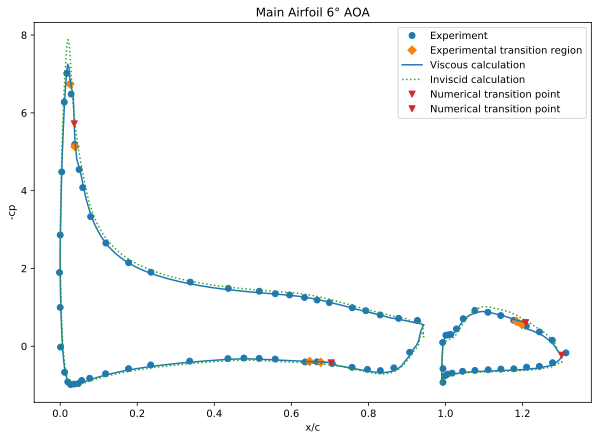

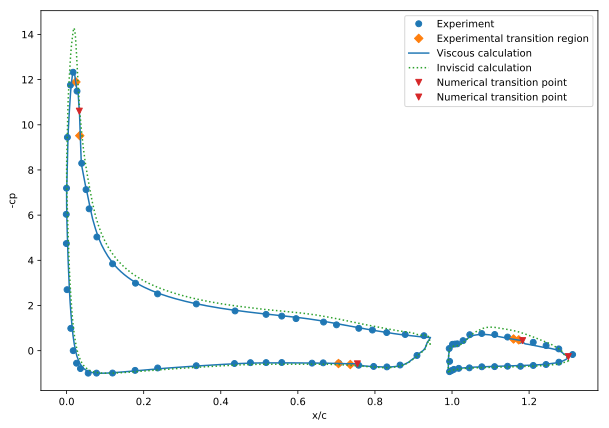

In [6]:

# Shorthand for plotting all info for a single AOA from the csv dataset
def plot_cp_exp(ax,EXPRES):
    ax.plot(EXPRES['EXPMAINCP_X'],EXPRES['EXPMAINCP_Y'],marker="o",linestyle = 'None', color="tab:blue",label="Experiment")
    ax.plot(EXPRES['EXPFLAPCP_X']+.1,EXPRES['EXPFLAPCP_Y'],marker="o",linestyle = 'None', color="tab:blue")
    ax.plot(EXPRES['EXPMAINTR_X'],EXPRES['EXPMAINTR_Y'],marker="D",linestyle = 'None', color="tab:orange",label="Experimental transition region")
    ax.plot(EXPRES['EXPFLAPTR_X']+.1,EXPRES['EXPFLAPTR_Y'],marker="D",linestyle = 'None', color="tab:orange")

# Shorthand for plotting all info from the calculations for a single AOA
def plot_cp(ax,p,bl):
    # A helper index, cp is a single array of pressures over all panel nodes
    IMF = [range(0,p.foils[0].N),range(p.foils[0].N,p.foils[0].N+p.foils[1].N)]
    
    ax.plot(np.array(p.foils[0].X[0,:]),-p.cp[IMF[0]],marker="None",color="tab:blue",label="Viscous calculation")
    ax.plot(np.array(p.foils[1].X[0,:]+.1),-p.cp[IMF[1]],marker="None",color="tab:blue")
    ax.plot(np.array(p.foils[0].X[0,:]),-p.cp_inviscid[IMF[0]],':',marker="None",color="tab:green",label="Inviscid calculation")
    ax.plot(np.array(p.foils[1].X[0,:]+.1),-p.cp_inviscid[IMF[1]],':',marker="None",color="tab:green")

    for k in range(2):
        tr_lo = np.interp(bl[k].ST+bl[k].bl_fl.node_tr_lo.xi[0],p.foils[k].S,p.foils[k].X[0,:]+k*.1)
        tr_up = np.interp(bl[k].ST-bl[k].bl_fl.node_tr_up.xi[0],p.foils[k].S,p.foils[k].X[0,:]+k*.1)
        cp_up = np.interp(bl[k].ST-bl[k].bl_fl.node_tr_up.xi[0],p.foils[k].S,np.asarray(p.cp[IMF[k]]).ravel())
        cp_lo = np.interp(bl[k].ST+bl[k].bl_fl.node_tr_lo.xi[0],p.foils[k].S,np.asarray(p.cp[IMF[k]]).ravel())
        ax.plot(tr_lo,-cp_lo,'v',color="tab:red",label="Numerical transition point")
        ax.plot(tr_up,-cp_up,'v',color="tab:red")

    ax.set_xlabel('x/c')
    ax.set_ylabel('-cp')

# Read and plot data for 6° AoA
EXPRES=np.genfromtxt("NLRCP55.csv",delimiter=",",names=True)
fig,ax = plt.subplots(1,1)
plot_cp_exp(ax,EXPRES)
plot_cp(ax,p6,bl6)
ax.set_title('Main Airfoil 6° AOA')
ax.legend()

# Read and plot data for 13.1° AoA
EXPRES=np.genfromtxt("NLRCP126.csv",delimiter=",",names=True)
fig,ax = plt.subplots(1,1)
plot_cp_exp(ax,EXPRES)
plot_cp(ax,p13,bl13)
ax.legend();



[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun Chen. *Calculation of multielement airfoil flows, including flap wells.* 34th Aerospace Sciences Meeting and Exhibit. 1996.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.

[6] Godin, P., D. W. Zingg, and T. E. Nelson. *High-lift aerodynamic computations with one-and two-equation turbulence models.* AIAA journal 35.2 (1997): 237-243.

[7] Haase, W. et al. *ECARP - European Computational Aerodynamics Research Projects: Validation of CFD Codes and Assessment of Turbulence Models.* Notes on Numerical Fluid Mechanics, Vol. 58, 1997. 